In [121]:
# vscode won't find the correct cwd when the jupyter server runs remotely (in docker)
import os
try:
    os.chdir('/catkin_ws/src/notebooks/') # notebook bath in docker
except:
    pass

In [122]:
# %%
import cv2
import gtsam
import numpy as np
import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display
from scipy.spatial.transform import Rotation as R
import gtsam.utils.plot as gtsam_plot
from warnings import warn
import rospy
import rosbag
import tf2_ros
from cv_bridge import CvBridge
bridge = CvBridge()
from std_msgs.msg import Header
from geometry_msgs.msg import PoseStamped, Point, Pose, TransformStamped, Transform
from sensor_msgs.msg import PointCloud2, PointField, Image
from sensor_msgs import point_cloud2 as pc2
import struct
from nav_msgs.msg import Path
import itertools
import tf
from msg_to_se3 import msg_to_se3

plt.rcParams['figure.figsize'] = [20, 10]


In [123]:
import os
os.system('roscore &')
os.system('rosrun rviz rviz -d ./rviz/gentest.rviz &')

0

In [124]:
rospy.init_node('sim_bag_slam', anonymous=True)

In [125]:
os.system("rosrun tf2_ros static_transform_publisher 0 0 0  0.5, 0.5, 0.5, 0.5 map z_ahead &")

0

In [126]:
_S = []


        




    
class Processor():
    def __init__(self, path):
        self.frames = glob.glob(path)
        self.frames.sort()
        self.pp = (601.8873, 183.1104)
        self.focal = 707.0912
        self.detector = cv2.AKAZE_create()
        # self.truth = KittiGroundTruth("/images/poses.txt")

        self.pointer = 1
        self.m_rotation = None
        self.m_translation = None
        self.transform = None

        frame = self.detectAndComputeFrame(0)
        self.prev_kps = frame.kps
        self.prev_descs = frame.descs
        self.bf = cv2.BFMatcher(cv2.NORM_HAMMING) # TODO replace?

        self.track = []
        self.processed_frames = []
        self.transforms = {}
        self.stars = []
        
    
    def detectAndComputeFrame(self, img):
        (next_kps, next_descs) = self.detector.detectAndCompute(img, None)
        frame = Frame(0, next_kps, next_descs)
        return frame

    def estimate_transform(self, frame1, frame2, global_transform=None, debug=False):
        matches = self.bf.knnMatch(frame1.descs, frame2.descs, k=2)
        
        matches_prev = []
        matches_next = []
        
        if debug:
            debug_frames = [cv2.imread(self.frames[frame1.id]), cv2.imread(self.frames[frame2.id])]

        matches = list(filter(lambda m: m[0].distance < 0.8*m[1].distance, matches))
        if len(matches) < 500:
            return None

        for m,n in matches:
            matches_prev.append(frame1.kps[m.queryIdx].pt)
            matches_next.append(frame2.kps[m.trainIdx].pt)

            if debug:
                pa = (int(matches_prev[-1][0]),int(matches_prev[-1][1]))
                pb = (int(matches_next[-1][0]),int(matches_next[-1][1]))
                debug_frames[0] = cv2.line(debug_frames[0], pa, pb, (0,255,0), 1) 
                debug_frames[1] = cv2.line(debug_frames[1], pa, pb, (0,255,0), 1) 
                     

        matches_prev = np.array(matches_prev)
        matches_next = np.array(matches_next)

        E, mask = cv2.findEssentialMat(matches_prev, matches_next, focal=self.focal, pp=self.pp, method=cv2.RANSAC, prob=0.999, threshold=1.0)
        points, R_est, t_est, mask_pose = cv2.recoverPose(E, matches_prev, matches_next, focal=self.focal, pp=self.pp)
        
        # x,y,z,scale = self.truth.getPoseAndAbsoluteScale(frame1.id, frame2.id)
        # t_est *= scale

        transform = Transform(frame1, frame2, R_est, t_est)

        if global_transform is not None:
            points_4d = cv2.triangulatePoints(zero_transform(), transform.projection_matrix(), matches_prev.T, matches_next.T)
            points_3d = points_4d[0:3] / points_4d[3]
            ponits_3d = global_transform.t + (global_transform.R @ points_3d)
            for i,(m,n) in enumerate(matches):
                star = next((s for s in self.stars if s.has(frame1, m.queryIdx)), None)
                if star:
                    star.add_observation(frame2, m.trainIdx)
                else:
                    self.stars.append(Star(frame1, m.queryIdx, frame2, m.trainIdx, ponits_3d[:,i]))

        if debug:
            return transform, debug_frames
        return transform


def zero_projection_matrix():
    return np.hstack((np.identity(3), np.zeros((3,1))))

# p = Processor("/images/*.png")
# _f = [p.detectAndComputeFrame(0), p.detectAndComputeFrame(1), p.detectAndComputeFrame(2)]
# _t = p.estimate_transform(_f[0], _f[1], Transform(Frame(-2, [], []), Frame(-1, [], []), np.identity(3), np.zeros((3,1))))
# _t = p.estimate_transform(_f[1], _f[2], _t)
# plt.imshow(p.last_frame)




In [127]:
class Viz():
    frame_id = "z_ahead"
    pub_image = rospy.Publisher('render', Image, queue_size=1)
    pub_camera = rospy.Publisher('camera', PoseStamped, queue_size=1)
    pub_path_initial_estimate = rospy.Publisher("initial_estimate", Path, queue_size=1)
    pub_path_ground_truth = rospy.Publisher("truth", Path, queue_size=1)
    pub_path_optimized = rospy.Publisher("optimized", Path, queue_size=1)

    @classmethod
    def keypoints(cls, img, frame):
        for x, y in [kp.pt for kp in frame.kps]:
            # print("center", center)
            # print(img.shape)
            cv2.circle(img, (int(x), int(y)), radius=1, color=(0,255,128), thickness=1)
        cls.pub_image.publish(bridge.cv2_to_imgmsg(img, encoding="rgb8"))

    @classmethod
    def camera_pose(cls, transform):
        cls.pub_camera.publish(transform.to_ros_pose_stamped())

    @staticmethod
    def path(transforms):
        path = Path()
        path.poses = [t.to_ros_pose_stamped() for t in transforms]
        path.header.frame_id = Viz.frame_id
        return path
    @classmethod
    def path_raw(cls, transforms):
        cls.pub_path_initial_estimate.publish(cls.path(transforms))
    @classmethod
    def path_truth(cls, ros_poses):
        path = Path()
        path.poses = ros_poses
        path.header.frame_id = "ground_truth_zero"
        cls.pub_path_ground_truth.publish(path)
    @classmethod
    def path_optimized(cls, ros_poses):
        path = Path()
        path.poses = ros_poses
        path.header.frame_id = Viz.frame_id
        cls.pub_path_optimized.publish(path)

class Frame():
    def __init__(self, id, kps, descs):
        self.id = id
        self.kps = kps
        self.descs = descs
    
    def symbol(self):
        return gtsam.symbol('X', self.id)

class Landmark():
    _id = itertools.count(0)

    def __init__(self, frame1, kp_index1, frame2, kp_index2):
        self.symbol = gtsam.symbol('S', next(self._id))
        self.observations = { frame1: kp_index1, frame2: kp_index2 }
    def add_observation(self,frame, kp_index):
        if frame in self.observations:
            if kp_index == self.observations[frame]:
                return
            # warn("Star: tried to add a Frame #{} observation twice with differect KP indices ({}, {})".format(frame.id, self.observations[frame], kp_index))
            del self.observations[frame]
        else:
            self.observations[frame] = kp_index
    def has(self, frame, kp_index):
        return frame in self.observations and self.observations[frame] == kp_index

class Transform():
    def __init__(self, frame1, frame2, R, t):
        assert (frame1 is None and frame2 is None) or (frame1.id < frame2.id)

        self.frame1 = frame1
        self.frame2 = frame2
        self.R = R
        self.t = t

    @staticmethod
    def from_ros_msg(msg):
        h = msg_to_se3(ts)
        return Transform(None, None, h[:3,:3], h[:3,3:])
    
    def to_ros_pose_stamped(self):
        pose = PoseStamped()
        pose.header.frame_id = Viz.frame_id
        pose.header.stamp = rospy.Time.now()
        pose.pose.position.x = self.t[0][0]
        pose.pose.position.y = self.t[1][0]
        pose.pose.position.z = self.t[2][0]
        quaternion = R.from_matrix(self.R).as_quat()
        pose.pose.orientation.x = quaternion[0]
        pose.pose.orientation.y = quaternion[1]
        pose.pose.orientation.z = quaternion[2]
        pose.pose.orientation.w = quaternion[3]
        return pose
        
    def __add__(self, transform2):
        assert isinstance(transform2, Transform)
        t = self.t + (self.R @ transform2.t)
        R = transform2.R @ self.R
        return Transform(self.frame1, transform2.frame2, R, t)

    def projection_matrix(self):
        x,y,z = self.t.T[0]
        rot = self.R
        return np.hstack((rot, [[x],[y],[z]]))

class DecodeImageMsg():
    @classmethod
    def push(cls, msg):
        cv_image = bridge.imgmsg_to_cv2(msg, desired_encoding='passthrough')
        id = int(msg.header.stamp.to_time() * 10**9)
        DetectAndComputeFrame.push(id, cv_image)

class DetectAndComputeFrame():
    detector = cv2.AKAZE_create()

    @classmethod
    def push(cls, id, img):
        (next_kps, next_descs) = cls.detector.detectAndCompute(img, None)
        frame = Frame(id, next_kps, next_descs)
        Viz.keypoints(img, frame)
        CollectFrames.push(frame)

class CollectFrames():
    frames = []

    @classmethod
    def push(cls, frame):
        cls.frames.append(frame)
        if len(cls.frames) > 1:
            EstimateTransform.push(cls.frames[-2], cls.frames[-1], raise_on_match_fail=True, add_to_initial_estimate=True)

            go_back = np.minimum(len(cls.frames)-2, 3)
            extra_count = np.minimum(go_back, 1)
            extras = -(np.random.choice(go_back, extra_count, replace=False) + 3)
            for i in extras:
                EstimateTransform.push(cls.frames[i], cls.frames[-1], raise_on_match_fail=False,add_to_initial_estimate=False)

class EstimateTransform():
    bf = cv2.BFMatcher(cv2.NORM_HAMMING) # TODO replace?
    focal = 277.1
    pp = (160.5, 120.5)

    @classmethod
    def push(cls, frame1, frame2, raise_on_match_fail=False, add_to_initial_estimate=False):
        matches = cls.bf.knnMatch(frame1.descs, frame2.descs, k=2)
        
        matches_prev = []
        matches_next = []
        idx_prev = []
        idx_next = []

        matches = list(filter(lambda m: m[0].distance < 0.8*m[1].distance, matches))
        if len(matches) < 40:
            if raise_on_match_fail:
                raise Exception("Failed to match frames. Found {} matches".format(len(matches)))
            return None

        for m,n in matches:
            matches_prev.append(frame1.kps[m.queryIdx].pt)
            matches_next.append(frame2.kps[m.trainIdx].pt)
            idx_prev.append(m.queryIdx)
            idx_next.append(m.trainIdx)

        matches_prev = np.array(matches_prev)
        matches_next = np.array(matches_next)

        E, mask = cv2.findEssentialMat(matches_prev, matches_next, focal=cls.focal, pp=cls.pp, method=cv2.RANSAC, prob=0.999, threshold=1.0)
        
        for i, is_good_kp_index in enumerate(mask):
            if is_good_kp_index:
                CollectLandmarks.push(frame1, idx_prev[i], frame2, idx_next[i])
            
        
        points, R_est, t_est, mask_pose = cv2.recoverPose(E, matches_prev, matches_next, focal=cls.focal, pp=cls.pp)
        
        # x,y,z,scale = self.truth.getPoseAndAbsoluteScale(frame1.id, frame2.id)
        # convert to Z-up
        # z_up_rotation = R.from_rotvec(np.array([np.pi/2,np.pi/2,0])).as_matrix()
        # t_est = z_up_rotation @ t_est
        # R_est = R_est @ z_up_rotation
        # t = self.t + (self.R @ transform2.t)
        # R = transform2.R @ self.R
        # t_est = np.array([t_est[0],t_est[2],t_est[1]])
        scale = 0.05 # TODO
        t_est *= scale

        transform = Transform(frame1, frame2, R_est, t_est)

        CollectTransforms.push(transform)
        Graph.push_transform(transform)
        if add_to_initial_estimate:
            InitialPathEstimate.push(transform)

class CollectLandmarks():
    landmarks = []

    @classmethod
    def push(cls, frame1, kp_index1, frame2, kp_index2):
        landmark = next((s for s in cls.landmarks if s.has(frame1, kp_index1)), None)
        
        if landmark:
            landmark.add_observation(frame2, kp_index2)
        else:
            landmark = next((s for s in cls.landmarks if s.has(frame2, kp_index2)), None)
            if landmark:
                landmark.add_observation(frame1, kp_index2)
            else:
                cls.landmarks.append(Landmark(frame1, kp_index1, frame2, kp_index2))
        
class CollectTransforms():
    transforms = []

    @classmethod
    def push(cls, transform):
        cls.transforms.append(transform)

class InitialPathEstimate():
    path = []
    global_transform = None

    @classmethod
    def push(cls, transform): 
        if cls.global_transform is None:
            cls.global_transform = transform
        else:
            cls.global_transform = cls.global_transform + transform 
        cls.path.append(cls.global_transform)

        rot = gtsam.Rot3(cls.global_transform.R)
        point = gtsam.Point3(cls.global_transform.t.T[0])
        key = cls.global_transform.frame2.symbol()
        Graph.initial_estimate.insert(key, gtsam.Pose3(rot, point))

        Viz.camera_pose(cls.global_transform)
        Viz.path_raw(cls.path)

class GroundTruth():
    path = []
    last_transform = None
    broadcaster = tf2_ros.StaticTransformBroadcaster()

    @classmethod
    def push(cls, ros_transform):
        cls.last_transform = ros_transform
        pose = PoseStamped(pose=Pose(ros_transform.translation, ros_transform.rotation))
        cls.path.append(pose)
        Viz.path_truth(cls.path)
    
    @classmethod
    def trigger_zero_pose(cls):
        # TODO handle when last_transform = None
        static_transformStamped = TransformStamped()
        static_transformStamped.header.stamp = rospy.Time.now()
        static_transformStamped.header.frame_id = "ground_truth_zero"
        static_transformStamped.child_frame_id = "map"
        static_transformStamped.transform.translation.x = cls.last_transform.translation.x
        static_transformStamped.transform.translation.y = cls.last_transform.translation.y
        static_transformStamped.transform.translation.z = cls.last_transform.translation.z
        static_transformStamped.transform.rotation.x = 0
        static_transformStamped.transform.rotation.y = 0
        static_transformStamped.transform.rotation.z = 1
        static_transformStamped.transform.rotation.w = 0
        cls.broadcaster.sendTransform(static_transformStamped)

class Graph():
    PRIOR_NOISE = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.3]*6))
    ODOMETRY_NOISE = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.3]*6))

    graph = gtsam.NonlinearFactorGraph()
    initial_estimate = gtsam.Values()

    @classmethod
    def push_transform(cls, transform):
        return
        rot = gtsam.Rot3(transform.R)
        point = gtsam.Point3(transform.t.T[0])
        key1 = transform.frame1.symbol()
        key2 = transform.frame2.symbol()
        cls.graph.add(gtsam.BetweenFactorPose3(key1, key2, gtsam.Pose3(rot, point), cls.ODOMETRY_NOISE))

    @classmethod
    def dogleg_optimizer(cls):
        params = gtsam.DoglegParams()
        params.setVerbosity('TERMINATION')
        return gtsam.Cal3_S2(cls.graph, cls.initial_estimate, params)

    @classmethod
    def gauss_newton_optimizer(cls):
        parameters = gtsam.GaussNewtonParams()
        # Stop iterating once the change in error between steps is less than this value
        parameters.setRelativeErrorTol(1e-5)
        # Do not perform more than N iteration steps
        parameters.setMaxIterations(1000)
        # Create the optimizer ...
        return gtsam.GaussNewtonOptimizer(cls.graph, cls.initial_estimate, parameters)

    @classmethod
    def lm_optimizer(cls):
        params = gtsam.LevenbergMarquardtParams()
        params.setVerbosityLM("ERROR")
        return gtsam.LevenbergMarquardtOptimizer(cls.graph, cls.initial_estimate, params)

    @classmethod
    def pull_result(cls):
        optimizer = cls.lm_optimizer() 
        # ... and optimize
        result = optimizer.optimize()

        def to_ros_pose_stamped(pose3):
            quaternion = pose3.rotation().quaternion()
            pose = PoseStamped()
            pose.header.frame_id = Viz.frame_id
            pose.header.stamp = rospy.Time.now()
            pose.pose.position.x = pose3.x()
            pose.pose.position.y = pose3.y()
            pose.pose.position.z = pose3.z()
            pose.pose.orientation.x = quaternion[0]
            pose.pose.orientation.y = quaternion[1]
            pose.pose.orientation.z = quaternion[2]
            pose.pose.orientation.w = quaternion[3]
            return pose

        optimized = np.array([to_ros_pose_stamped(result.atPose3(f.symbol())) for f in CollectFrames.frames])
        Viz.path_optimized(optimized)

        return result




        
bag = rosbag.Bag('/bags/01.bag')
got_first_frame = False
for m in list(bag.read_messages())[:1200]:
    # help(m.timestamp)
    # print(m.topic, m.timestamp)
    if m.topic.endswith("/front/image_raw"):
        DecodeImageMsg.push(m.message)
        if not got_first_frame:
            got_first_frame = True
            GroundTruth.trigger_zero_pose()
        # rospy.sleep(1.)
    elif m.topic.endswith("/pose_static"):
        t = next(t.transform for t in m.message.transforms if t.child_frame_id == "costar_husky_sensor_config_1")
        GroundTruth.push(t)

# Graph.graph.add(gtsam.PriorFactorPose3(CollectFrames.frames[0].symbol(), gtsam.Pose3(), Graph.PRIOR_NOISE))
# Graph.initial_estimate.insert(CollectFrames.frames[0].symbol(), gtsam.Pose3())
# result = Graph.pull_result()

In [ ]:
CollectLandmarks.landmarks[0].observations.keys()

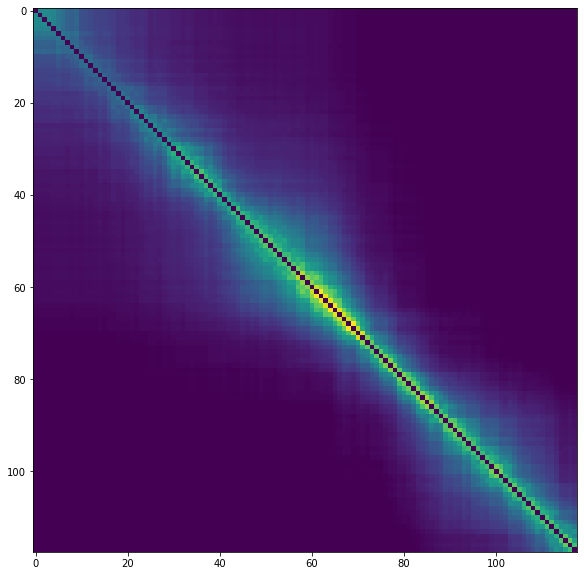

In [129]:
cmap = np.zeros((len(CollectFrames.frames), len(CollectFrames.frames)))

for l in CollectLandmarks.landmarks:
    for f1 in l.observations.keys():
        for f2 in l.observations.keys():
            if f1 != f2:
                x = CollectFrames.frames.index(f1)
                y = CollectFrames.frames.index(f2)
                cmap[x, y] += 1

plt.imshow(cmap)

433100000000 263 (250.60501098632812, 76.4387435913086)
433150000000 264 (261.5856018066406, 75.31494140625)
433200000000 249 (272.2706604003906, 74.5898208618164)
5662


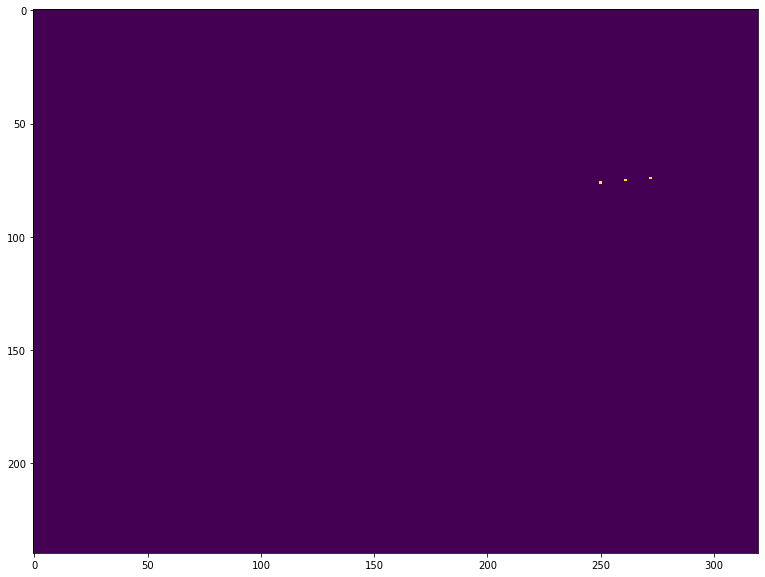

In [130]:
cmap = np.zeros((240,320))

l = CollectLandmarks.landmarks[5360]
for frame, kp_idx in l.observations.items():
    x, y = frame.kps[kp_idx].pt
    cmap[int(y), int(x)] += 1
    print(frame.id, kp_idx, frame.kps[kp_idx].pt)

plt.imshow(cmap)
print(len(CollectLandmarks.landmarks))

In [ ]:
smart.

In [131]:
graph = Graph.graph.clone()
initial_estimate = gtsam.Values(Graph.initial_estimate)
measurement_noise = gtsam.noiseModel.Isotropic.Sigma(
        2, 1.0)  # one pixel in u and v
focal = 277.1
pp = (160.5, 120.5)
K = gtsam.Cal3_S2(focal, focal, 0.0, pp[0], pp[1])

# Simulated measurements from each camera pose, adding them to the factor graph
for l in CollectLandmarks.landmarks:
    if len(l.observations) < 10:
        continue
    # Every landmark represent a single landmark, we use shared pointer to init the factor, and then insert measurements
    smart_factor = gtsam.SmartProjectionPose3Factor(measurement_noise, K)

    for frame, kp_index in l.observations.items():

        try:
            xy = np.array(frame.kps[kp_index].pt, dtype=np.float64)
        except Exception:
            print(len(frame.kps), kp_index)

        # Add measurement to smart factor
        smart_factor.add(xy, frame.symbol())
    
    # Insert the smart factor in the graph
    graph.push_back(smart_factor)

# Add a prior on pose x0
# 30cm std on x,y,z 0.1 rad on roll,pitch,yaw
pose_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array(
    [0.1, 0.1, 0.1, 0.3, 0.3, 0.3]))  
pose = gtsam.Pose3()
graph.push_back(gtsam.PriorFactorPose3(CollectFrames.frames[0].symbol(), pose, pose_noise))

# Because the structure-from-motion problem has a scale ambiguity, the problem is
# still under-constrained. Here we add a prior on the second pose x1, so this will
# fix the scale by indicating the distance between x0 and x1.
# Because these two are fixed, the rest of the poses will be also be fixed.
pose = initial_estimate.atPose3(CollectFrames.frames[1].symbol())
graph.push_back(gtsam.PriorFactorPose3(CollectFrames.frames[1].symbol(), pose, pose_noise)) # Add directly to graph
graph.print_("Factor Graph:\n")

initial_estimate.insert(CollectFrames.frames[0].symbol(), gtsam.Pose3())



# Create the initial estimate to the solution
# Intentionally initialize the variables off from the ground truth
# delta = gtsam.Pose3(gtsam.Rot3.Rodrigues(-0.1, 0.2, 0.25), gtsam.Point3(0.05, -0.10, 0.20))
# for i, pose in enumerate(poses):
#     initial_estimate.insert(X(i), pose.compose(delta))
# Pose3 delta(Rot3::Rodrigues(-0.1, 0.2, 0.25), Point3(0.05, -0.10, 0.20));
# for (size_t i = 0; i < poses.size(); ++i)
# initialEstimate.insert(i, poses[i].compose(delta));
initial_estimate.print_("Initial Estimates:\n");
# print(initial_estimate)

params = gtsam.LevenbergMarquardtParams()
# params.setMaxIterations(1)
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial_estimate, params)
result = optimizer.optimize()



152 180
152 170
198 240
273 282
445 447


In [132]:
def to_ros_pose_stamped(p3: gtsam.Pose3):
    translation = p3.translation()
    quaternion = p3.rotation().toQuaternion()
    pose = PoseStamped()
    pose.header.frame_id = Viz.frame_id
    pose.header.stamp = rospy.Time.now()
    pose.pose.position.x = translation[0]
    pose.pose.position.y = translation[1]
    pose.pose.position.z = translation[2]
    pose.pose.orientation.x = quaternion.x()
    pose.pose.orientation.y = quaternion.y()
    pose.pose.orientation.z = quaternion.z()
    pose.pose.orientation.w = quaternion.w()
    return pose

optimized = np.array([to_ros_pose_stamped(result.atPose3(f.symbol())) for f in CollectFrames.frames])
Viz.path_optimized(optimized)

In [ ]:
help(gtsam.LevenbergMarquardtParams())

In [ ]:
def viz_path(X, Y, Z, label):
    path_publisher = rospy.Publisher(label, Path, queue_size=1)

    path_msg = Path()
    path_msg.header.frame_id = 'map'
    for x, y, z in zip(X, Y, Z):
        pose_msg = PoseStamped()

        pose_msg.pose.position.x = x / 100
        pose_msg.pose.position.y = y / 100
        pose_msg.pose.position.z = z / 100
        pose_msg.pose.orientation.x = 0
        pose_msg.pose.orientation.y = 0
        pose_msg.pose.orientation.z = 0
        pose_msg.pose.orientation.w = 1
        path_msg.poses.append(pose_msg)

    path_publisher.publish(path_msg)
    
viz_path(track[:,0,2], track[:,0,0], track[:,0,1], label="raw_est")
viz_path(-track[:,1,2], track[:,1,0], track[:,1,1], label="truth")
viz_path(optimized[:,2], optimized[:,0], -optimized[:,1], label="optimized")

In [ ]:
"""
GTSAM Copyright 2010-2019, Georgia Tech Research Corporation,
Atlanta, Georgia 30332-0415
All Rights Reserved
See LICENSE for the license information
A script validating the Preintegration of IMU measurements
"""

import math

import gtsam
import matplotlib.pyplot as plt
import numpy as np
from gtsam.utils.plot import plot_pose3
from mpl_toolkits.mplot3d import Axes3D

IMU_FIG = 1
POSES_FIG = 2


class PreintegrationExample(object):

    @staticmethod
    def defaultParams(g):
        """Create default parameters with Z *up* and realistic noise parameters"""
        params = gtsam.PreintegrationParams.MakeSharedU(g)
        kGyroSigma = math.radians(0.5) / 60  # 0.5 degree ARW
        kAccelSigma = 0.1 / 60  # 10 cm VRW
        params.setGyroscopeCovariance(
            kGyroSigma ** 2 * np.identity(3, np.float))
        params.setAccelerometerCovariance(
            kAccelSigma ** 2 * np.identity(3, np.float))
        params.setIntegrationCovariance(
            0.0000001 ** 2 * np.identity(3, np.float))
        return params

    def __init__(self, twist=None, bias=None, dt=1e-2):
        """Initialize with given twist, a pair(angularVelocityVector, velocityVector)."""

        # setup interactive plotting
        plt.ion()

        # Setup loop as default scenario
        if twist is not None:
            (W, V) = twist
        else:
            # default = loop with forward velocity 2m/s, while pitching up
            # with angular velocity 30 degree/sec (negative in FLU)
            W = np.array([0, -math.radians(30), 0])
            V = np.array([2, 0, 0])

        self.scenario = gtsam.ConstantTwistScenario(W, V)
        self.dt = dt

        self.maxDim = 5
        self.labels = list('xyz')
        self.colors = list('rgb')

        # Create runner
        self.g = 10  # simple gravity constant
        self.params = self.defaultParams(self.g)

        if bias is not None:
            self.actualBias = bias
        else:
            accBias = np.array([0, 0.1, 0])
            gyroBias = np.array([0, 0, 0])
            self.actualBias = gtsam.imuBias.ConstantBias(accBias, gyroBias)

        self.runner = gtsam.ScenarioRunner(
            self.scenario, self.params, self.dt, self.actualBias)

        fig, self.axes = plt.subplots(4, 3)
        fig.set_tight_layout(True)

    def plotImu(self, t, measuredOmega, measuredAcc):
        plt.figure(IMU_FIG)

        # plot angular velocity
        omega_b = self.scenario.omega_b(t)
        for i, (label, color) in enumerate(zip(self.labels, self.colors)):
            ax = self.axes[0][i]
            ax.scatter(t, omega_b[i], color='k', marker='.')
            ax.scatter(t, measuredOmega[i], color=color, marker='.')
            ax.set_xlabel('angular velocity ' + label)

        # plot acceleration in nav
        acceleration_n = self.scenario.acceleration_n(t)
        for i, (label, color) in enumerate(zip(self.labels, self.colors)):
            ax = self.axes[1][i]
            ax.scatter(t, acceleration_n[i], color=color, marker='.')
            ax.set_xlabel('acceleration in nav ' + label)

        # plot acceleration in body
        acceleration_b = self.scenario.acceleration_b(t)
        for i, (label, color) in enumerate(zip(self.labels, self.colors)):
            ax = self.axes[2][i]
            ax.scatter(t, acceleration_b[i], color=color, marker='.')
            ax.set_xlabel('acceleration in body ' + label)

        # plot actual specific force, as well as corrupted
        actual = self.runner.actualSpecificForce(t)
        for i, (label, color) in enumerate(zip(self.labels, self.colors)):
            ax = self.axes[3][i]
            ax.scatter(t, actual[i], color='k', marker='.')
            ax.scatter(t, measuredAcc[i], color=color, marker='.')
            ax.set_xlabel('specific force ' + label)

    def plotGroundTruthPose(self, t, scale=0.3, time_interval=0.01):
        # plot ground truth pose, as well as prediction from integrated IMU measurements
        actualPose = self.scenario.pose(t)
        plot_pose3(POSES_FIG, actualPose, scale)
        t = actualPose.translation()
        self.maxDim = max([max(np.abs(t)), self.maxDim])
        ax = plt.gca()
        ax.set_xlim3d(-self.maxDim, self.maxDim)
        ax.set_ylim3d(-self.maxDim, self.maxDim)
        ax.set_zlim3d(-self.maxDim, self.maxDim)

        plt.pause(time_interval)

    def run(self, T=12):
        # simulate the loop
        for i, t in enumerate(np.arange(0, T, self.dt)):
            measuredOmega = self.runner.measuredAngularVelocity(t)
            measuredAcc = self.runner.measuredSpecificForce(t)
            if i % 25 == 0:
                self.plotImu(t, measuredOmega, measuredAcc)
                self.plotGroundTruthPose(t)
                pim = self.runner.integrate(t, self.actualBias, True)
                predictedNavState = self.runner.predict(pim, self.actualBias)
                plot_pose3(POSES_FIG, predictedNavState.pose(), 0.1)

        plt.ioff()
        plt.show()


if __name__ == '__main__':
    PreintegrationExample().run()

In [ ]:
help(cv2.findEssentialMat)